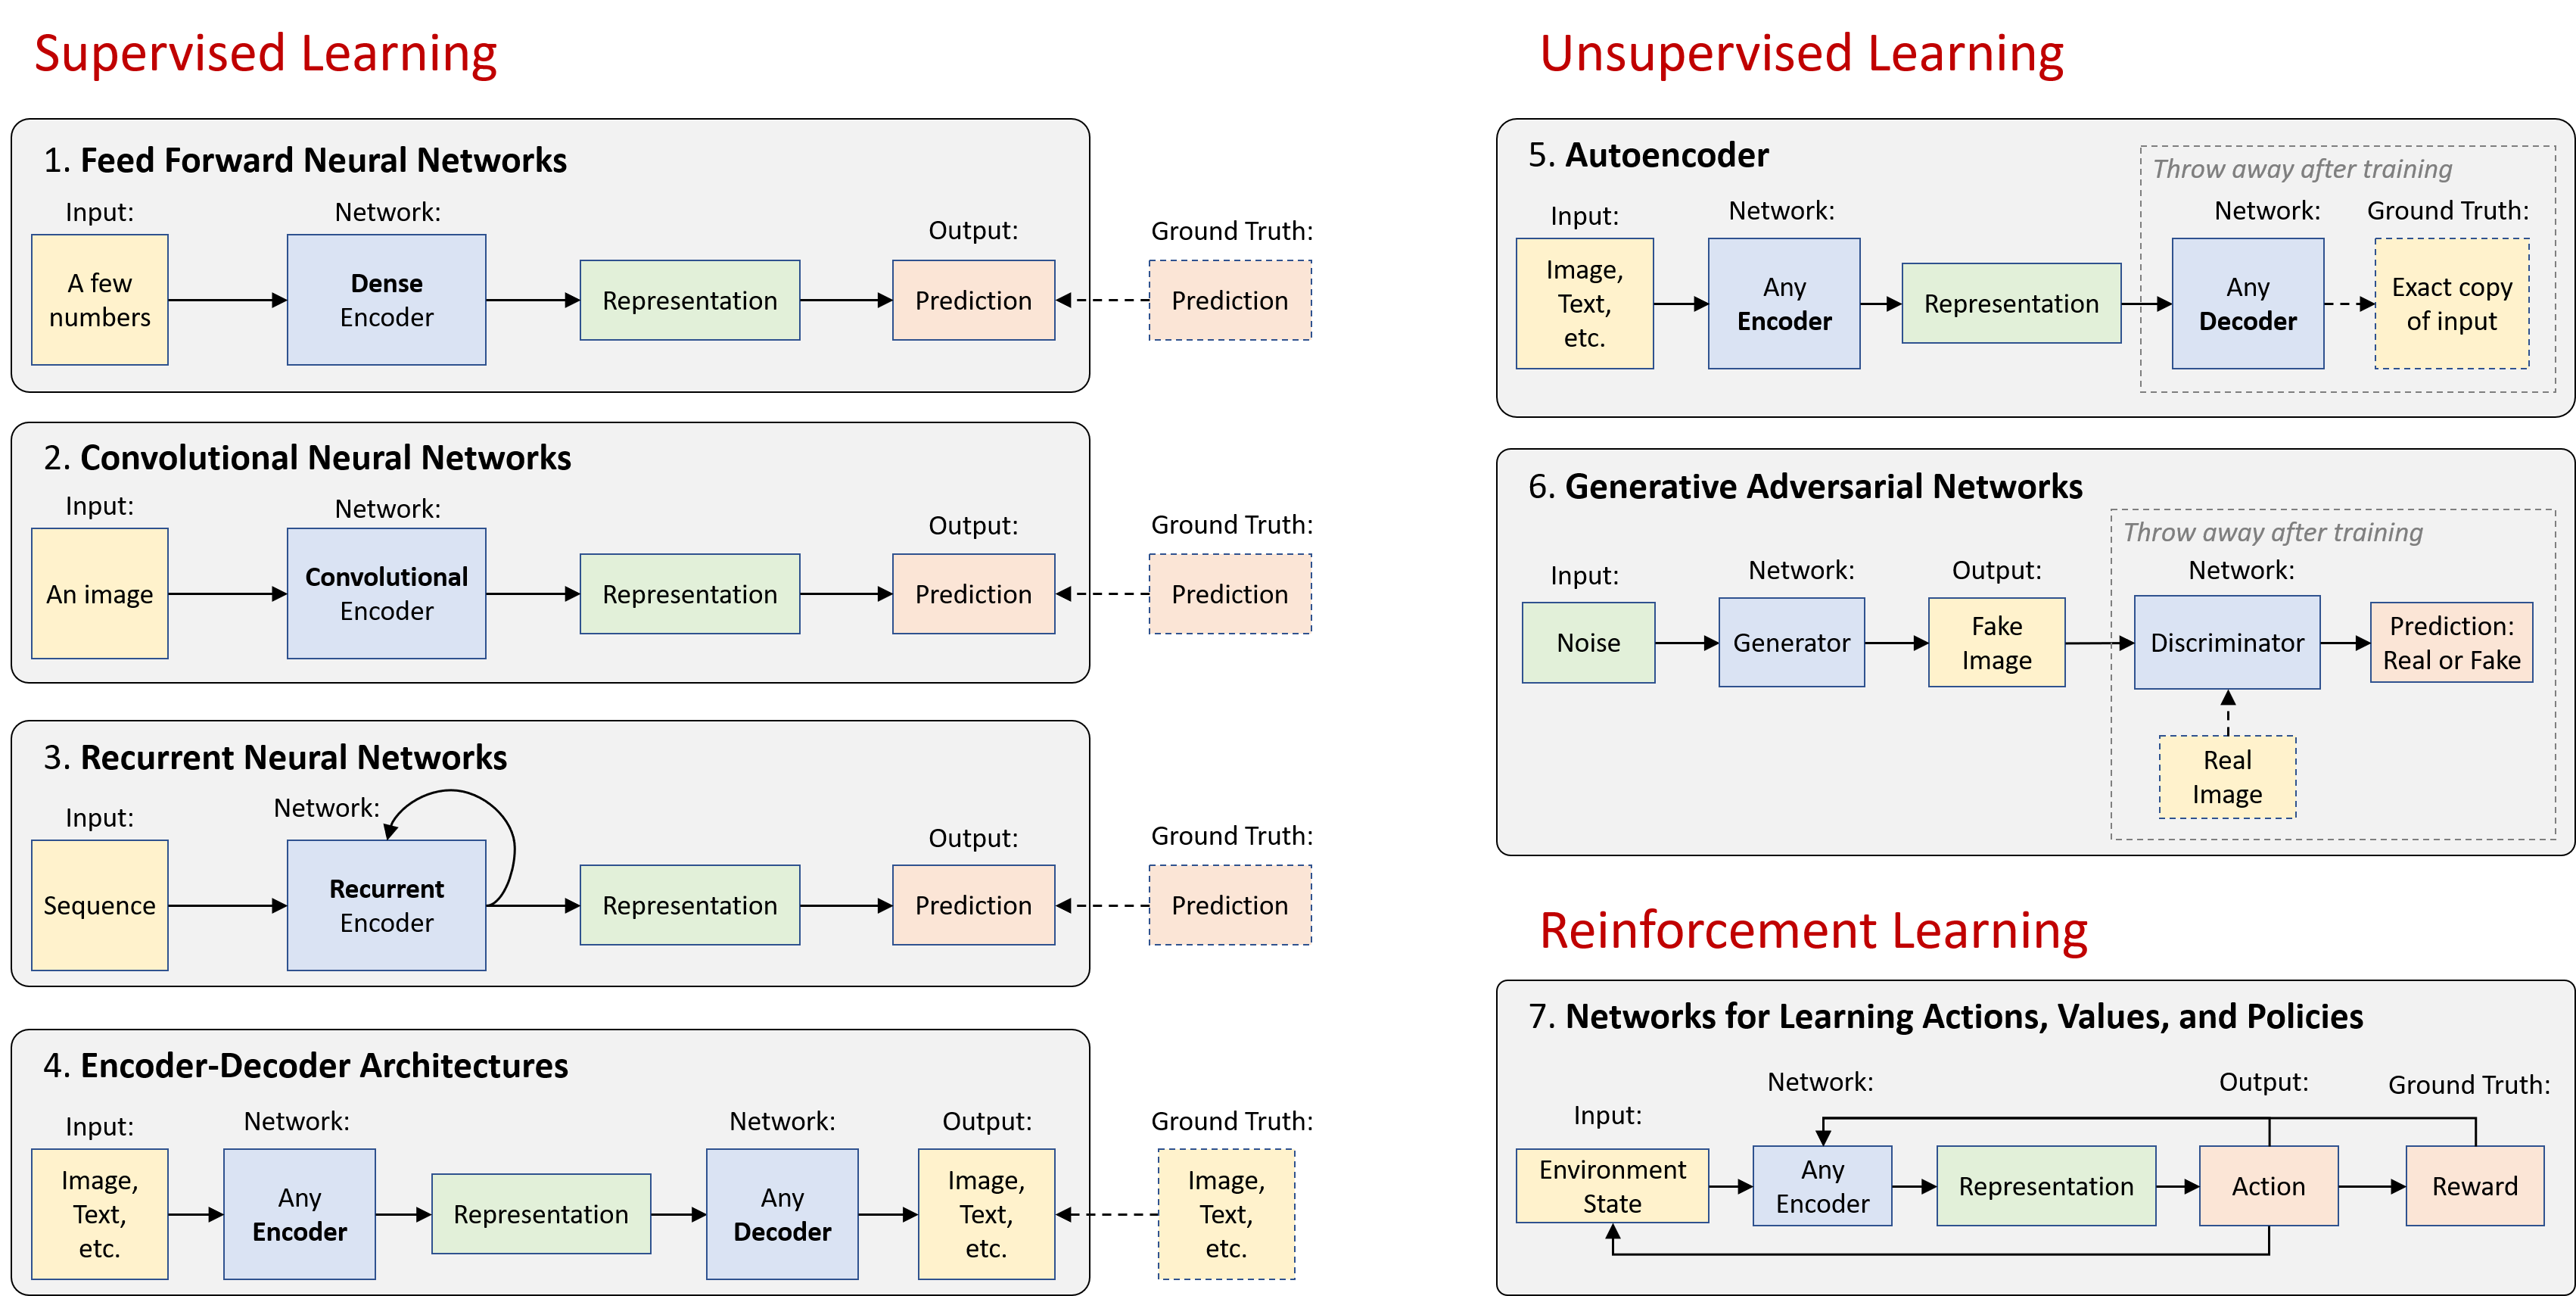## Deep Learning Basics
Types of Machine Learning
<img src="https://camo.githubusercontent.com/31b7167b6d8177d563324a6b729233a0ba02f0685abff5e585ae61efb841ea61/68747470733a2f2f692e696d6775722e636f6d2f45416c343772702e706e67"/>

### Some Deep Learning Teminology
1. <b>Feed Forward Neural Networks (FFNS) </b> - Classification and regression
2. <b>Convolution Neural Networks (CNNS)</b> - Image Classification, Object Detection.
3. <b>Recurrent Neural Networks (RNNS)</b> - Language Modeling, Speech Recognition/Generation
4. <b>Encoder-Decoder</b> - Semantic Segmentation, Machine Translation.
5. <b>AutoEncoder</b> - Unsupervised embeddings, denoising etc.
6. <b>Generative Adversarial Networks (GAN)</b> - Unsupervised generation of realistic images.
7. <b>Deep Reinforcement Learning</b> - Game Playing, Robotics.

### Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

### Part 1: Boston House Price Prediction with Feed Forward Networks

Difference b/w regression and classification. 
<img src="https://camo.githubusercontent.com/abf0ff147f1d1a3f9ac21a306f3490a1cb09f121a2c473e6e50f649fa135c3d4/68747470733a2f2f692e696d6775722e636f6d2f7676536f417a672e6a7067"/>

In [3]:
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std

### Build Model
We are building a Neural Net with 1 hidden layer of 20 neurons and use `MSE` as the loss function

In [4]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation='relu', input_shape=[len(train_features[0])]),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

### Train Model

In [5]:
# This helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

In [6]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

In [7]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

### Part 2: Classification of MNIST Dreams with CNN

In [8]:
# Load MNIST
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

Scale these values to a range of 0 to 1 before feeding the Neural Net


In [9]:
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [10]:
!nvidia-smi

In [11]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

### Build Model


In [12]:
model = keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train Model
Feed the Training Data to the Model

In [15]:
history = model.fit(train_images, train_labels, epochs=10)

### Evaluate Accuracy

In [16]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test Accuracy: ', test_acc)

In [19]:
mnist_dream_path = '../input/mnist-dream/mnist_dream.mp4'
mnist_prediction_path = '../working/mnist_dream_predicted.mp4'

def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes()
    image_ip = IPython.display.Image(data=ret)
    IPython.display.display(image_ip)
    
cap = cv2.VideoCapture(mnist_dream_path)
vw = None
frame = -1 # Counter for debugging (mostly), 0-indexed

# Go through all the frames and run our classifier on the high res MNIST images as they morph from number to number 
while True:
    frame += 1
    ret, img = cap.read()
    if not ret:
        break
        
    assert img.shape[0] == img.shape[1]
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))
       
    #preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels
    
    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)
    
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3        
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)
    
    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    
    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
        
    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)
            
        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)
        
        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    
    # if you don't want to save the output as a video, set this to False
    save_video = True
    
    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)
        
cap.release()
if vw is not None:
    vw.release()